In [1]:
import os.path

import matplotlib.pyplot as plt
import matplotlib

import wandb
import pandas as pd
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import numpy as np

/home/mbortkie/miniconda3/envs/c_r_l/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
project = "layer_norm"  # e.g., your project name
figures_path = f"./figures/{project}"
os.makedirs(figures_path, exist_ok=True)

In [4]:
metric = "eval/episode_success_any"
metric_label = "Success rate"
window_size = 10  # for smoothing the results
env = "ant_u_maze"
env_title_mapping = {
    "ant_ball": "Ant Ball",
    "ant": "Ant",
    "ant_big_maze": "Ant Big Maze",
    "ant_u_maze": "Ant U-Maze",
}
plot_legend= True if env=="ant" else False

In [5]:
h_dim=1024 
exp_names = [
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln",
]

exp_names_mapping = {
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_": "Depth 4",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_": "Depth 3",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_": "Depth 2",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln": "Depth 4 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln": "Depth 3 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln": "Depth 2 LN",
}

# 
# h_dim=512
# exp_names = [
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_",
# ]
# 
# exp_names_mapping = {
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_": "Depth 4",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_": "Depth 3",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_": "Depth 2",
# }

# h_dim=256
# exp_names = [
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_4",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_3",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_2",
# ]
# 
# exp_names_mapping = {
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_4": "Depth 4",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_3": "Depth 3",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_2": "Depth 2",
# }

# Energy functions
# exp_names = [
#     "ant_l_symmetric_infonce_ef_l1",
#     "ant_l_symmetric_infonce_ef_l2",
#     "ant_l_symmetric_infonce_ef_l2_no_sqrt",
#     "ant_l_symmetric_infonce_ef_dot",
#     "ant_l_symmetric_infonce_ef_cos",
# ]
# 
# exp_names_mapping = {
#     "ant_l_symmetric_infonce_ef_l1": "L1",
#     "ant_l_symmetric_infonce_ef_l2": "L2",
#     "ant_l_symmetric_infonce_ef_l2_no_sqrt": "L2 w/o sqrt",
#     "ant_l_symmetric_infonce_ef_dot": "Dot",
#     "ant_l_symmetric_infonce_ef_cos": "Cos",
# }

In [6]:
# Define filters for the run config (replace with your specific filters)
filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    # "config.n_hidden": 2,
    # "config.h_dim": 256,
    # "config.use_ln": True,
    # "config.env_name": env,
    # "config.env_name": {"$in": list(env_title_mapping.keys())},
    "config.exp_name": {"$in": exp_names},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)

In [7]:
len(runs)

90

In [8]:
# Function to extract metrics from runs
def extract_run_data(run):
    # Extract run config and metrics
    config = run.config
    summary = run.summary._json_dict
    # TODO: potentially just load csv
    if os.path.exists(f"./data/history_{run.id}.csv"):
        history = pd.read_csv(f"./data/history_{run.id}.csv")
    else:
        history = run.history(pandas=True)
        history.to_csv(f"./data/history_{run.id}.csv", index=False)
    # Combine run information into a single dictionary

    run_data = {
        "run_id": run.id,
        "name": run.name,
        **config,
        **summary
    }
    return run_data, history

def create_rliable_compatible_data(df, metric):
    return df[metric].to_numpy()

def moving_average_smoothing(data, window_size=3):
    """Apply a moving average filter to the last axis of the input data, ensuring no wrap-around."""
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode='edge')
    smoothed = np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    return smoothed

In [9]:
# Loop through the runs and collect data
all_histories = []

for run in runs:
    run_data, history = extract_run_data(run)
    all_histories.append(history)

In [10]:
data = {exp_names_mapping[elem]:[] for elem in exp_names}
seeds = {exp_names_mapping[elem]: [] for elem in exp_names}
for run, history in zip(runs, all_histories):
    a = create_rliable_compatible_data(history, metric)
    data[exp_names_mapping[run.config["exp_name"]]].append(a)
    seeds[exp_names_mapping[run.config["exp_name"]]].append(run.config["seed"])

In [11]:
data

{'Depth 4': [array([0.0546875, 0.0390625, 0.1875   , 0.34375  , 0.28125  , 0.40625  ,
         0.515625 , 0.4375   , 0.421875 , 0.5625   , 0.40625  , 0.53125  ,
         0.4765625, 0.6640625, 0.5859375, 0.4921875, 0.546875 , 0.578125 ,
         0.703125 , 0.640625 , 0.5234375, 0.59375  , 0.515625 , 0.625    ,
         0.6328125, 0.6796875, 0.65625  , 0.6328125, 0.6796875, 0.71875  ,
         0.6796875, 0.75     , 0.65625  , 0.7421875, 0.828125 , 0.78125  ,
         0.7265625, 0.7109375, 0.734375 , 0.6953125, 0.75     , 0.7109375,
         0.7421875, 0.75     , 0.7109375, 0.7578125, 0.84375  , 0.765625 ,
         0.75     , 0.828125 ]),
  array([0.0390625, 0.1796875, 0.1484375, 0.1953125, 0.1796875, 0.265625 ,
         0.3125   , 0.359375 , 0.40625  , 0.484375 , 0.5546875, 0.5859375,
         0.40625  , 0.5546875, 0.5      , 0.515625 , 0.71875  , 0.5625   ,
         0.6171875, 0.6796875, 0.671875 , 0.7265625, 0.71875  , 0.6640625,
         0.734375 , 0.5859375, 0.6328125, 0.5703125, 0.6

In [12]:
data = {key: np.array(elem)[:,None,:] for key, elem in data.items()}

In [13]:
# TODO: same shapes assert
for exp_name in exp_names:
    print(data[exp_names_mapping[exp_name]].shape)

(15, 1, 50)
(15, 1, 50)
(15, 1, 50)
(15, 1, 50)
(15, 1, 50)
(15, 1, 50)


In [14]:
for key, item in data.items():
    data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item) 


In [15]:
np.arange(0, 55, 5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [20]:
data = {key:elem for key, elem in data.items() if "Depth 4" in key}

In [21]:
data.keys()

dict_keys(['Depth 4', 'Depth 4 LN'])

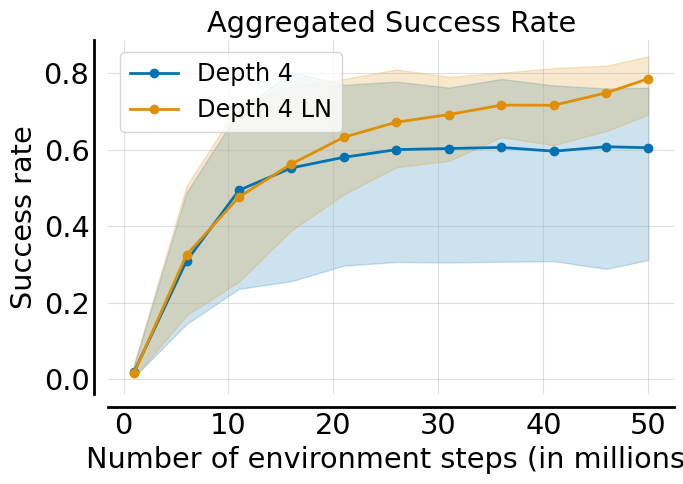

In [24]:
frames = np.arange(0, 55, 5)
frames[-1] -=1
ale_frames_scores_dict = {
    algorithm: score[:, :, frames]
    for algorithm, score in data.items()
}
iqm = lambda scores: np.array(
    [metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])]
)
iqm_scores, iqm_cis = rly.get_interval_estimates(
    ale_frames_scores_dict, iqm, reps=500
)
plot_utils.plot_sample_efficiency_curve(
    frames + 1,
    iqm_scores,
    iqm_cis,
    algorithms=list(data.keys()),
    xlabel=r"Number of environment steps (in millions)",
    ylabel=metric_label,
    # legend=plot_legend,
    legend=True,
    grid_alpha=0.4
)
# plt.title(f"{env_title_mapping[env]}", fontsize="xx-large")
plt.title(f"Aggregated Success Rate", fontsize="xx-large")
plt.tight_layout()
plt.savefig(os.path.join(figures_path, f"{metric_label}_all.png"))

In [17]:
data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}

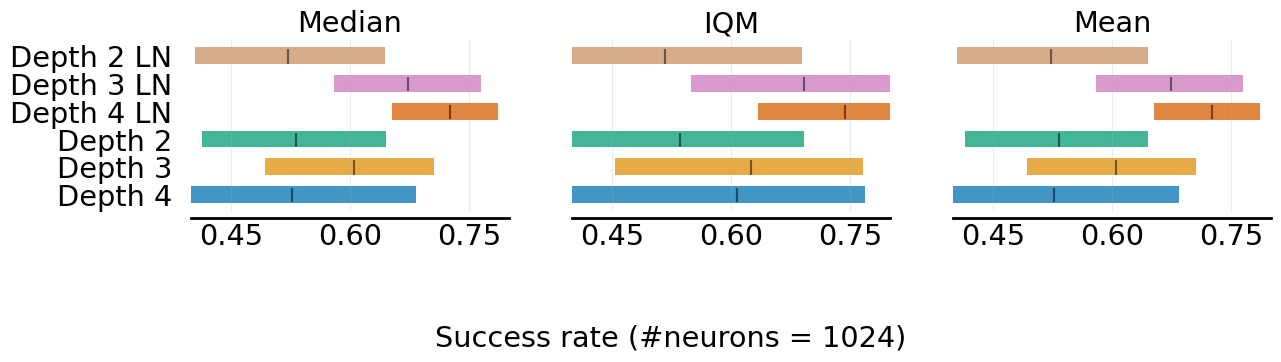

In [18]:
aggregate_func = lambda x: np.array(
    [
        metrics.aggregate_median(x),
        metrics.aggregate_iqm(x),
        metrics.aggregate_mean(x),
    ]
)
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
    data_flattened, aggregate_func, reps=500
)
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores,
    aggregate_score_cis,
    metric_names=["Median", "IQM", "Mean"],
    algorithms=list(data.keys()),
    xlabel=f"{metric_label} (#neurons = {h_dim})",
    grid_alpha=0.4,
    max_ticks=3,
    subfigure_width=4,
    xlabel_y_coordinate=-0.5,
)
plt.subplots_adjust(wspace=0.2, left=0.0)
for ax in axes:
    ax.set_xlim((0.4, 0.8))


plt.savefig(
    os.path.join(figures_path, f"{metric_label}_all_{h_dim}.png"), bbox_inches="tight"
)